# PPO algorithm

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_single_action_policy

%matplotlib inline

* System parameters

In [ ]:
T = 5 # terminal time step
max_steps = 20 # number of time steps
random.seed(1989)

* Create training and evaluation environments and define actions

In [ ]:
# validate environment
from environments.qubit_env import QubitResonantContEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0

environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [ ]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 1000
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/ppo_qubit_resonant_cont/"

In [ ]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
)

agent.initialize()

In [ ]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

In [7]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 24.89346694946289


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 0.421027272939682
step = 150: loss = 0.9988065958023071


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 3.588613271713257
step = 250: loss = 8.794869422912598
step = 300: loss = 5.175065517425537
step = 350: loss = 0.3176044821739197


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 400: loss = 0.046547189354896545
step = 450: loss = 1.9154460430145264
step = 500: loss = 2.83437180519104
step = 550: loss = 5.0851054191589355
step = 600: loss = 0.49612101912498474
step = 650: loss = 0.07425656914710999
step = 700: loss = 0.054652731865644455
step = 750: loss = -0.010529004037380219


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 800: loss = 0.019918352365493774
step = 850: loss = -0.05970200151205063
step = 900: loss = -0.023996694013476372
step = 950: loss = -0.04937759414315224
step = 1000: loss = 0.03896016255021095
step = 1050: loss = 0.07234230637550354
step = 1100: loss = -0.04918179661035538
step = 1150: loss = -0.04533270001411438
step = 1200: loss = -0.0454581156373024
step = 1250: loss = -0.09989512711763382
step = 1300: loss = -0.05069616064429283
step = 1350: loss = -0.04727070406079292
step = 1400: loss = -0.029101938009262085
step = 1450: loss = -0.06575683504343033
step = 1500: loss = -0.01740884967148304
step = 1550: loss = -0.07224639505147934


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 1600: loss = -0.09456432610750198
step = 1650: loss = -0.012830682098865509
step = 1700: loss = -0.05867474898695946
step = 1750: loss = -0.01068461686372757
step = 1800: loss = -0.031163934618234634
step = 1850: loss = -0.06900458037853241
step = 1900: loss = -0.01958523318171501
step = 1950: loss = -0.03618674725294113
step = 2000: loss = 0.01052326150238514
step = 2050: loss = -0.04667958617210388
step = 2100: loss = -0.07205143570899963
step = 2150: loss = -0.0747031643986702
step = 2200: loss = 0.02110331878066063
step = 2250: loss = -0.08925595134496689
step = 2300: loss = 0.059036653488874435
step = 2350: loss = 0.004766443278640509
step = 2400: loss = 0.16209205985069275
step = 2450: loss = -0.059710822999477386
step = 2500: loss = 0.06703553348779678
step = 2550: loss = 0.07100332528352737
step = 2600: loss = -0.03570958971977234
step = 2650: loss = -0.08372724056243896
step = 2700: loss = -0.016542896628379822
step = 2750: loss = -0.5647704005241394
step = 2800: loss =

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 3200: loss = -0.0935576930642128
step = 3250: loss = -0.06656467169523239
step = 3300: loss = -0.023457176983356476
step = 3350: loss = -0.057496704161167145
step = 3400: loss = -0.06889311224222183
step = 3450: loss = -0.027376485988497734
step = 3500: loss = -0.17054615914821625
step = 3550: loss = -0.13039426505565643
step = 3600: loss = -0.05582639202475548
step = 3650: loss = -0.10215781629085541
step = 3700: loss = 0.08857323229312897
step = 3750: loss = -0.08637821674346924
step = 3800: loss = -0.060150887817144394
step = 3850: loss = -0.0669056698679924
step = 3900: loss = 0.08213939517736435
step = 3950: loss = 0.02643829956650734
step = 4000: loss = -0.05555245280265808
step = 4050: loss = 0.10862259566783905
step = 4100: loss = -0.0769236832857132
step = 4150: loss = -0.084621861577034
step = 4200: loss = -0.0694456547498703
step = 4250: loss = -0.2884783148765564
step = 4300: loss = -0.056950606405735016
step = 4350: loss = -0.020093491300940514
step = 4400: loss = -

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 6400: loss = -0.15947268903255463
step = 6450: loss = -0.03652695566415787
step = 6500: loss = -0.08712313324213028
step = 6550: loss = -0.20821210741996765
step = 6600: loss = -0.022017642855644226
step = 6650: loss = -0.026245050132274628
step = 6700: loss = -0.11617760360240936
step = 6750: loss = -0.11545517295598984
step = 6800: loss = -0.13500061631202698
step = 6850: loss = -0.01993381790816784
step = 6900: loss = -0.019272327423095703
step = 6950: loss = -0.11151005327701569
step = 7000: loss = -0.08483566343784332
step = 7050: loss = -0.05984392389655113
step = 7100: loss = -0.04105750471353531
step = 7150: loss = -0.009534524753689766
step = 7200: loss = -0.006734074093401432
step = 7250: loss = -0.005613415502011776
step = 7300: loss = -0.052774667739868164
step = 7350: loss = -0.03408502787351608
step = 7400: loss = -0.010491128079593182
step = 7450: loss = -0.05051948502659798
step = 7500: loss = -0.01371042337268591
step = 7550: loss = -0.002638527425006032
step = 

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (657240) so Table uniform_table is accessed directly without gRPC.


step = 12800: loss = 1.2144975662231445
step = 12850: loss = 0.2798951268196106
step = 12900: loss = 0.3987540006637573
step = 12950: loss = 0.008728919550776482
step = 13000: loss = -0.022745266556739807
step = 13050: loss = 0.016475461423397064
step = 13100: loss = 0.5030936002731323
step = 13150: loss = 1.6879494190216064
step = 13200: loss = 0.028323322534561157
step = 13250: loss = 0.5492265820503235
step = 13300: loss = 0.13121426105499268
step = 13350: loss = 1.419862151145935
step = 13400: loss = -0.02456510066986084
step = 13450: loss = 0.003845461644232273
step = 13500: loss = 0.009627975523471832
step = 13550: loss = -0.017325613647699356
step = 13600: loss = 0.22293570637702942
step = 13650: loss = -0.0661083310842514
step = 13700: loss = -0.024466414004564285
step = 13750: loss = -0.10574419051408768
step = 13800: loss = -0.02555636130273342
step = 13850: loss = -0.0496894009411335
step = 13900: loss = -0.1797090619802475
step = 13950: loss = -0.05315478891134262
step = 14

In [8]:
# checkpointer.save(train_step_counter)

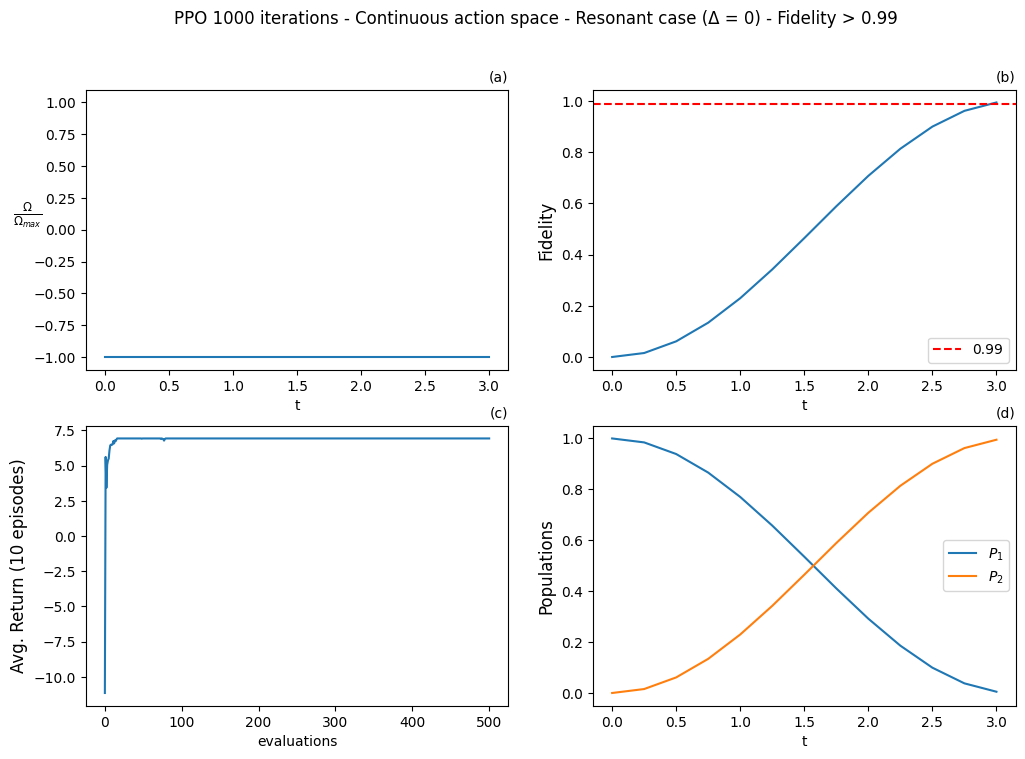

In [9]:
greedy_actions, optimal_omegas, states, fidelities = extract_single_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO {num_iterations} iterations - Continuous action space - Resonant case (Δ = 0) - Fidelity > 0.99')

ax1.step(time_span, optimal_omegas, where = 'post')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)

plt.show()